# PSU DS 200 
## Project Utility Jupyter Notebook 2
### November 19, 2019
### Updated November 22, 2019

### Instructor: John Yen

#### This Jupyter Notebook is intended to be used to construct Project Deliverables #2 for the Mini-project of DS 200. 

## The goal of this utility is to extract important features from a model so that you can combine them with the visualization of decision trees to do the following:
- To identify, among the very large number (hundreds) of features, what features are actually important for the model.
- By combining important features with the decision tree visualizations to interpret the role they play in the model (e.g., Does the appearance (or lack of appearance) of a word in a tweet more likely indicate a positive tweet for ...?)
- By comparing important features generated in different folds in a k-fold cross validation, we can not only identify multiple sets of important features, but also start to generate additional questions regarding these features and the class (e.g., positive/negative sentiment) you want to predict from a tweet.

#### Acknowledgement: The datascience module is developed by University of California Berkeley for its data 8 course.

#### Why extracting important features from a model is important?
- This helps people using the model to better understand the patterns/knowledge the model learns from the data.
- Being able to understand the knowledge captured in a model is the first step toward helping people to develop a suitable level of "trust" on the model.
- Comparing important features across different folds of a cross validation can also indicate whether the importance of the feature is "reliable".

#### How does sklearn help to identify important features
- The decision tree learning of sklearn module provides feature_importances, which is an array of "feature names" and associated "importance measure".  The importance measure of all features add up to 1.


In [1]:
!pip install datascience

     |████████████████████████████████| 51kB 728kB/s eta 0:00:011
     |████████████████████████████████| 92kB 1.2MB/s eta 0:00:011
     |████████████████████████████████| 13.0MB 64kB/s  eta 0:00:011
     |████████████████████████████████| 215kB 29.8MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/65/e0/eb35e762802015cab1ccee04e8a277b03f1d8e53da3ec3106882ec42558b/Jinja2-2.10.3-py2.py3-none-any.whl
     |████████████████████████████████| 92kB 1.5MB/s  eta 0:00:01
  Created wheel for datascience: filename=datascience-0.15.3-cp35-none-any.whl size=44582 sha256=82fea087befcb3bbc5b6de463b175010126ba7a86bf0bd9f41a0049148aa7ed0
  Stored in directory: /home/nbuser/.cache/pip/wheels/b8/37/0a/80274866028f6485c5957f0e1acf8e2b755fbe9dd0fd4ad275
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=19851 sha256=ee6ef38ae73ad54cd2e83665e21bef969d7a71e0ce6ffa6a9fab424a3b82a9f3
  Stored in directory: /home/nbuser/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b1294

In [2]:
import datascience
import numpy as np
import graphviz

from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 


from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.base import ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

from graphviz import *

import pandas as pd
import numpy as np

from sklearn.externals import joblib

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [3]:
t1 = Table.read_table("Tagged-Tweets.csv", sep =',')
t1.show(10)

Support,text
1,**everyone screaming that were gonna die in 12 years bec ...
0,@colin_ban88 @starryplough67 @doc53384809 I said I took ...
1,@Darryl0007 @KTHopkins Hard man but you won't think it b ...
1,@eilperin @Fahrenthold @afreedma @jdawsey1 I hope the ot ...
1,@EliasCrimLaw @olcarcajou @FairQuestions @eliasmunshya @ ...
0,@Fahrenthold And Mulvaney said that climate change will ...
0,@FormerSenior @QandA @SBSNews Maybe stop lying. Climate ...
0,@GrantMcroberts Basically people who want us to do somet ...
0,@horsetoilets @LouiseStephen9 @drandyphung But the clima ...
1,@JGunlock @steph93065 Take them very seriously. 48 perce ...


### The code below extract the "class label" from the CSV file to find out the total number of positive/supportive vs negative/non-supportive tweets in the labelled data set.
### If you use Climage Change tweets, the column label for the class label is 'Support'.
### If you use Airline Sentiment tweets, the column label for the class label is 'airline_sentiment' (as shown in Lab9)

In [4]:
t1_positive = t1.where('Support', are.equal_to(1))
t1_negative = t1.where('Support', are.equal_to(0))
t1_positive

Support,text
1,**everyone screaming that were gonna die in 12 years bec ...
1,@Darryl0007 @KTHopkins Hard man but you won't think it b ...
1,@eilperin @Fahrenthold @afreedma @jdawsey1 I hope the ot ...
1,@EliasCrimLaw @olcarcajou @FairQuestions @eliasmunshya @ ...
1,@JGunlock @steph93065 Take them very seriously. 48 perce ...
1,@RichLowry @RichLowry you are obviously not very smart. ...
1,@ukmav @hilltopgina @elliethebookgal Yet he contributes ...
1,| Tell Congress: Take Action to Against Climate Change h ...
1,A new U.N. report predicts more powerful storms increase ...
1,Antarctica latest: Scientists to drill THREE KILOMETRES ...


In [5]:
t1_negative

Support,text
0,@colin_ban88 @starryplough67 @doc53384809 I said I took ...
0,@Fahrenthold And Mulvaney said that climate change will ...
0,@FormerSenior @QandA @SBSNews Maybe stop lying. Climate ...
0,@GrantMcroberts Basically people who want us to do somet ...
0,@horsetoilets @LouiseStephen9 @drandyphung But the clima ...
0,@kentlivenews Bet @GretaThunberg will be pissed that cli ...
0,@KTHopkins @DoringHaak These climate change freaks dont ...
0,@MarkYoungTruth I feel like this kid is a climate change ...
0,@postpolitics Why should I believe a young girl with asp ...
0,@TheOfficerTatum @Just_Fargo Can anyone PLEASE show me a ...


In [6]:
data = t1_positive.append(t1_negative)

In [7]:
data

Support,text
1,**everyone screaming that were gonna die in 12 years bec ...
1,@Darryl0007 @KTHopkins Hard man but you won't think it b ...
1,@eilperin @Fahrenthold @afreedma @jdawsey1 I hope the ot ...
1,@EliasCrimLaw @olcarcajou @FairQuestions @eliasmunshya @ ...
1,@JGunlock @steph93065 Take them very seriously. 48 perce ...
1,@RichLowry @RichLowry you are obviously not very smart. ...
1,@ukmav @hilltopgina @elliethebookgal Yet he contributes ...
1,| Tell Congress: Take Action to Against Climate Change h ...
1,A new U.N. report predicts more powerful storms increase ...
1,Antarctica latest: Scientists to drill THREE KILOMETRES ...


In [8]:
# Use the data for constructing a Decision Tree Classifier
data_tagged_X= list(data['text'])
data_tagged_Y= list(data['Support'])

print('tagged data input size', len(data_tagged_X))
print('tagged data target prediction size', len(data_tagged_Y))

tagged data input size 344
tagged data target prediction size 344


### Important Features for the Model with Best Max_depth

In Mini-project Deliverable #1, you have chosen a best value for max_depth of the decision tree model based on Stratified KFold Cross Validation.

In this Mini-project Deliverable, you will use the max_depth you chose from Deliverable #1 to construct decision trees and extract 10 most important features from your model.  If we only do this on one 
decision tree, we do not know how reliable is the feature importance result (just like we are not
as certain of the f1 value of testing data based on only one training-testing split).  

### Using Stratified KFold CV to Identify Reliably Important Features

Therefore, we can use Stratified KFold Cross Validation to construct k sets of important features, one
for each model constructed in each fold. This will provide us information on how reliable is the feature importance across the k fold.  For example, if a feature is always in the top 3 important feature in all
k folds, the high importance of the feature is quite reliable.  On the other hand, if a feature occurs in top 10 important feature only once among the k fold, the importance of the feautre is not as reliable as others that occur more often.

In [9]:
## Set the max_depth parameter value to be the one you chose for Mini-Project Deliverable #1

Best_max_depth= 4

### Stratified KFold Cross Validation
StratifiedKFold is a function in sklearn under the submodule model_selection.
#### Notice: In the beginning of this notebook, we import StratifiedKFold using the following python code:
    from sklearn.model_selection import StratifiedKFold
    
The n_splits parameter of StratifiedKFold indicates how many folds to use.  For example, 
n_splits=5 means Stratified 5-fold cross validation.


In [10]:
# Use Stratified Kfold Cross Validation so that
#   each fold contains the same ratio of positive/negative instances
k = 8
skf = StratifiedKFold(n_splits= k , random_state=1, shuffle= True)

In [11]:
### Set the range of max_depth to be around the 
low_max_depth = Best_max_depth - 1
high_max_depth = Best_max_depth + 1
training_performance_table = np.empty( [high_max_depth+1, k+1, 5] )
testing_performance_table = np.empty( [high_max_depth+1, k+1, 5] )

### Prepare the table to store total feature_importance (for each feature) across k folds; as well as
### the average, minimum, and maximum of feature_importance (for each feature) across k folds
feature_importance_k_fold_sum = np.empty( [high_max_depth+1, 1])
feature_importance_k_fold_avg = np.empty( [high_max_depth+1, 1])

### Create a CountVectorizer to map word features of all words in labelled data to index of word frequency matrix
### Note that this does NOT mean all tweets are used for training, it only means we create the columns of
### word frequency matrix using all words in the labelled tweets.  
count_vect = CountVectorizer(token_pattern='((?:([@#]|[0-9]|[a-z]|[A-Z])+))', analyzer= 'word', min_df=2)
x_all = list(data['text'])
count_vect = count_vect.fit(x_all)


### Calculate Average, Minimum, and Maximum f1 score across folds 
The first dimension of training_performance_table refers to a specific max_depth value.
The second dimension of training_performance_table refers to the number of a fold (in a k-fold).
The third dimension of training_performance_table saves f1 score in index "3".

For example, the code below returns an array of f1_score for all k folds for max_depth set to 7.

In [12]:
feature_names = count_vect.get_feature_names()
### Turn feature_names into an array so that we can iterate over its elements
feature_names_array = np.asarray(feature_names)
WF_dimension = len(feature_names)

feature_importance_array = np.empty([k+1, WF_dimension])

### Extract only words/hashtags from feature_names into a list of words only
words_only_list = list()

for i in range(0,WF_dimension):
    # Extract the first word of each (word, character) pair in feature_names_array
    words_only_list.append(feature_names_array[i,0])

print(words_only_list)


['#climateaction', '#climatechange', '#climatestrike', '#extentionrebellion', '#fridaysforfuture', '#gretathunberg', '000', '1', '10', '100', '11', '12', '16', '2', '2019', '3', '300', '5', '50', '500', '60', '7', '9', '924', '@', '@afreedma', '@aoc', '@cathmckenna', '@cnn', '@collinsdict', '@extinctionr', '@fahrenthold', '@greenpeace', '@gretathunberg', '@hauwertsr', '@hoya97', '@inactionnever', '@junkscience', '@justintrudeau', '@kthopkins', '@markdice', '@realdonaldtrump', '@sensanders', '@skynews', '@telegraphnews', '@thehill', '@wired', '@yalee360', 'a', 'about', 'absolutely', 'abuse', 'across', 'action', 'activism', 'activist', 'activists', 'actual', 'actually', 'address', 'adults', 'after', 'against', 'agenda', 'air', 'al', 'all', 'already', 'am', 'amazing', 'america', 'americans', 'amp', 'an', 'and', 'andrew', 'angry', 'answers', 'any', 'anyone', 'ardern', 'are', 'around', 'articles', 'as', 'ask', 'aspergers', 'at', 'attempt', 'attention', 'b', 'back', 'backlash', 'bad', 'based

In [13]:
for depth in range(low_max_depth, high_max_depth+1):
    
    ### Prepare the feature_importance_array to store all feature importance weights for all k folds
    feature_names = count_vect.get_feature_names()
    WF_dimension = len(feature_names)
    feature_importance_array = np.empty([k+1, WF_dimension])
    
    fold = 1
    print("***** Maximum Depth of Decision Tree is ", depth, "******")
    for train_index, test_index in skf.split(data_tagged_X, data_tagged_Y):
        print("Fold Number:", fold)
     #   print("Training Data Index:", train_index)
 #       print("Testing Data Index:", test_index)  
        x_train= list(data.take(train_index)['text'])     
    #    print("Training Data:", x_train)
        y_train= list(data.take(train_index)['Support'])
    #    print("Training Data Target Output:", y_train)
        x_test= list(data.take(test_index)['text'])
    #    print("Testing Data:", x_test)
        y_test= list(data.take(test_index)['Support'])
    #   print("Testing Data Target Output:", y_test)
    
    #   We use transform here, rather than fit_transform, because the word frequency columns have been identified 
    #   earlier using fit
        X_word_vect = count_vect.transform(x_train)
        clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = 100, max_depth=depth, \
                                  min_samples_leaf =2)
        clf.fit(X_word_vect, y_train)
        ### Use the model generated to predict for training data
        predicted_training_y = clf.predict(X_word_vect)
        train_p = metrics.precision_score(y_train, predicted_training_y)
        train_r = metrics.recall_score(y_train, predicted_training_y)
        train_f1= metrics.f1_score(y_train, predicted_training_y)
        training_performance_table[depth, fold, 0]=depth
        training_performance_table[depth, fold, 1]=train_p
        training_performance_table[depth, fold, 2]=train_r
        training_performance_table[depth, fold, 3]=train_f1
        print("Max depth is ", depth, "Prediction Performance for Training Data f1:", train_f1)
        
        ### Use the model generated to predict for testint data
        x_test_word_vect = count_vect.transform(x_test)
        predicted_testing_y = clf.predict(x_test_word_vect)
        
        test_p= metrics.precision_score(y_test, predicted_testing_y)
        test_r= metrics.recall_score(y_test, predicted_testing_y)
        test_f1 = metrics.f1_score(y_test, predicted_testing_y)
        testing_performance_table[depth, fold, 0]=depth
        testing_performance_table[depth, fold, 1]=test_p
        testing_performance_table[depth, fold, 2]= test_r
        testing_performance_table[depth, fold, 3]= test_f1
    #   print("Prediction Performance for Testing Data f1:", test_f1)  
    
        ### Store feature importance of the model as the i-th row in feature_importance_array  
        ### where i is the number of current fold     
        feature_imp = clf.feature_importances_
        ### We store feature importance of kth fold in fold-i row of feature_importance_array
        ### because the first row of the array has index 0.
        feature_importance_array[fold-1] = feature_imp
    #   print("Feature_importance_array:")
    #   print(feature_importance_array)
        
        ### Combine feature importance of this model and feature names to find top 20 important features
        feature_imp_names = zip(feature_imp, words_only_list)
        top_20_features = sorted(feature_imp_names, reverse=True)[:21]
        print("Top 20 important features for fold ", fold)
        for importance, name in top_20_features:
            print(name, importance)
            
        ### Store a visualization of the decision tree model
        dot_data= tree.export_graphviz(clf, out_file=None, feature_names=count_vect.get_feature_names())
        graph = graphviz.Source(dot_data)
        #### Create a string (to be used as the name of the file for storing the deicion tree visualization)
        #### We include fold number in the file name so that we can compare trees with the feature importance of different folds.
        graph_file_name = "ProjectDecisionTree_MaxDepth_" + str(depth) + "_Fold_" + str(fold)
        graph.render(graph_file_name)
        
        fold=fold+1 
    ### Convert Feature Importance Array for all k folds to a Panda DataFrame
    ### with column headings being features (words_only)
    feature_importance_k_fold_DF = pd.DataFrame(data=feature_importance_array, columns=words_only_list)
    
    ### Calculate the mean of feature importance for all words across all k folds
    feature_imp_k_fold_avg = np.mean(feature_importance_array, axis=0)
    # df2 = pd.DataFrame(data=feature_imp_k_fold_avg, columns=words_only_list)
    ### Add the average as the last row to the feature_importance_k_fold_DF
    feature_importance_k_fold_DF.loc[k] = feature_imp_k_fold_avg
    
    ### Sort the feature_importance_k_fold_DF by row k (i.e., average of feature importance)
    sorted_feature_importance_k_fold_DF=feature_importance_k_fold_DF.sort_values(by= k, axis='columns', ascending=False)
    print("Feature_importance_k_fold_DF sorted")
    print(sorted_feature_importance_k_fold_DF)
    ### Save the sorted feature importance DF as a CSV file 
    filename2 = "SortedFeatureImportanceKFoldMaxDepth_" + str(depth) + "_for_" + str(k) + "_Fold" + ".csv"
    sorted_feature_importance_k_fold_DF.to_csv(filename2)       
    
    ### Print top 30 features with highest average feature importance across all folds
    feature_imp_avg_words = zip(feature_imp_k_fold_avg, words_only_list)
    top_30_K_fold_features = sorted(feature_imp_avg_words, reverse=True)[:31]
    print("Top 30 important features across all folds")
    for importance, word in top_30_K_fold_features:
            print(word, importance)

***** Maximum Depth of Decision Tree is  3 ******
Fold Number: 1
Max depth is  3 Prediction Performance for Training Data f1: 0.7625
Top 20 important features for fold  1
but 0.2994551095934845
than 0.23846287516933495
are 0.23251805591961144
@gretathunberg 0.22956395931756904
zero 0.0
zealand 0.0
youtube 0.0
youth 0.0
yourself 0.0
your 0.0
young 0.0
you 0.0
york 0.0
yet 0.0
yesterday 0.0
yes 0.0
years 0.0
year 0.0
wrong 0.0
write 0.0
would 0.0
Fold Number: 2
Max depth is  3 Prediction Performance for Training Data f1: 0.7751605995717344
Top 20 important features for fold  2
our 0.3605673093625372
german 0.32851357316228197
no 0.3109191174751808
zero 0.0
zealand 0.0
youtube 0.0
youth 0.0
yourself 0.0
your 0.0
young 0.0
you 0.0
york 0.0
yet 0.0
yesterday 0.0
yes 0.0
years 0.0
year 0.0
wrong 0.0
write 0.0
would 0.0
worst 0.0
Fold Number: 3
Max depth is  3 Prediction Performance for Training Data f1: 0.7850877192982456
Top 20 important features for fold  3
over 0.36543965571476233
is 0.32

Fold Number: 6
Max depth is  4 Prediction Performance for Training Data f1: 0.7981651376146789
Top 20 important features for fold  6
more 0.2584312777196876
is 0.20407333386129
same 0.19037004617636047
biden 0.18852263825816623
the 0.1586027039844958
zero 0.0
zealand 0.0
youtube 0.0
youth 0.0
yourself 0.0
your 0.0
young 0.0
you 0.0
york 0.0
yet 0.0
yesterday 0.0
yes 0.0
years 0.0
year 0.0
wrong 0.0
write 0.0
Fold Number: 7
Max depth is  4 Prediction Performance for Training Data f1: 0.773109243697479
Top 20 important features for fold  7
our 0.2690141921546048
or 0.25263882785156117
biden 0.24266288442185532
german 0.23568409557197867
zero 0.0
zealand 0.0
youtube 0.0
youth 0.0
yourself 0.0
your 0.0
young 0.0
you 0.0
york 0.0
yet 0.0
yesterday 0.0
yes 0.0
years 0.0
year 0.0
wrong 0.0
write 0.0
would 0.0
Fold Number: 8
Max depth is  4 Prediction Performance for Training Data f1: 0.7770700636942675
Top 20 important features for fold  8
no 0.35419703955517867
our 0.2005982347703287
more 0.

Feature_importance_k_fold_DF sorted
         is     biden    german      more       our        no       her  \
0  0.000000  0.118378  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.147232  0.171033  0.000000  0.187721  0.161873  0.000000   
2  0.152124  0.149286  0.000000  0.137111  0.000000  0.000000  0.137114   
3  0.143965  0.000000  0.162339  0.000000  0.000000  0.000000  0.104149   
4  0.134684  0.000000  0.000000  0.115810  0.000000  0.000000  0.117247   
5  0.152496  0.140875  0.000000  0.193115  0.000000  0.000000  0.000000   
6  0.164653  0.202708  0.196878  0.000000  0.224720  0.000000  0.000000   
7  0.083708  0.000000  0.140147  0.157380  0.171775  0.303304  0.000000   
8  0.092403  0.084275  0.074489  0.067046  0.064913  0.051686  0.039834   

      there       are    action      ...             thunberg          every  \
0  0.137144  0.143693  0.000000      ...         0.000000e+00   0.000000e+00   
1  0.000000  0.000000  0.138373      ...         0.00

In [14]:
f1_array=training_performance_table[Best_max_depth, 1:k+1:1, 3]

#### Numpy offers a convenient way to calculate the average, the minimum, and the maximum value of a given array:
    np.average returns the average of a given array
    np.amin returns the minimum value of a given array
    np.amax regturns the maximum value of a given array

In [15]:
np.average(f1_array)

0.7845144839606706

In [16]:
np.amin(training_performance_table[ Best_max_depth , 1:k+1:1, 3])

0.7702127659574469

In [17]:
np.amax(training_performance_table[ Best_max_depth , 1:k+1:1, 3])

0.7981651376146789

### We want to calculate the average performance across all folds for each max_depth so that we can compare them. 

In [18]:
cv_training_f1_summary = np.empty( [high_max_depth+1, 3])
cv_testing_f1_summary = np.empty( [high_max_depth+1, 3])
first_fold = 1
last_fold = 5+1
for depth in range(low_max_depth, high_max_depth+1):
    train_f1_array = training_performance_table[depth, first_fold:last_fold:1 , 3]
    cv_training_f1_summary[depth, 0] = np.average(train_f1_array)
    cv_training_f1_summary[depth, 1] = np.amin(train_f1_array)
    cv_training_f1_summary[depth, 2] = np.amax(train_f1_array)
    test_f1_array = testing_performance_table[depth, first_fold:last_fold:1, 3]
    cv_testing_f1_summary[depth, 0] = np.average(test_f1_array)
    cv_testing_f1_summary[depth, 1] = np.amin(test_f1_array)
    cv_testing_f1_summary[depth, 2] = np.amax(test_f1_array)

### We want to plot the average of f1 scores (across all k folds) for each max_depth, and compare the average of f1 scores for training data and testing data

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [20]:
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning )

In [21]:
depth=np.linspace(low_max_depth, high_max_depth, high_max_depth-low_max_depth+1)
print(depth)

[3. 4. 5.]


In [22]:
avg_f1_training = cv_training_f1_summary[low_max_depth:high_max_depth+1, 0]
min_f1_training = cv_training_f1_summary[low_max_depth:high_max_depth+1, 1]
avg_f1_testing = cv_testing_f1_summary[low_max_depth:high_max_depth+1, 0]
min_f1_testing = cv_testing_f1_summary[low_max_depth:high_max_depth+1, 1]

### The following code for plotting average f1 

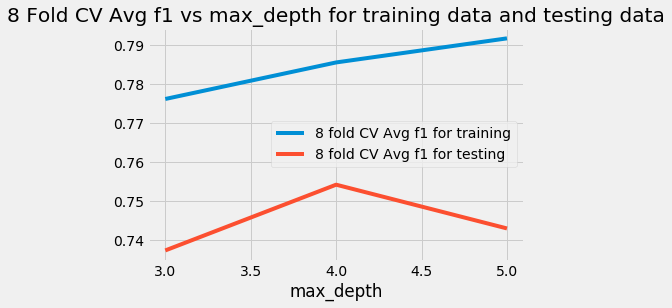

In [23]:
plt.plot(depth, avg_f1_training, label="8 fold CV Avg f1 for training")
plt.plot(depth, avg_f1_testing, label="8 fold CV Avg f1 for testing")
plt.xlabel('max_depth')
plt.title('8 Fold CV Avg f1 vs max_depth for training data and testing data')
plt.legend()
plt.show()

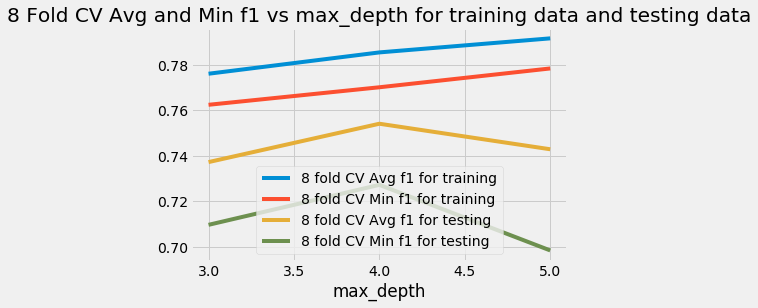

In [24]:
plt.plot(depth, avg_f1_training, label="8 fold CV Avg f1 for training")
plt.plot(depth, min_f1_training, label="8 fold CV Min f1 for training")
plt.plot(depth, avg_f1_testing, label="8 fold CV Avg f1 for testing")
plt.plot(depth, min_f1_testing, label="8 fold CV Min f1 for testing")
plt.xlabel('max_depth')
plt.title('8 Fold CV Avg and Min f1 vs max_depth for training data and testing data')
plt.legend()
plt.show()